In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_excel('data/IncidentiModificato.xlsx', index_col='VERBALE')

X = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y = df['Mezzo']

sc = StandardScaler()
X_std = sc.fit_transform(X)

# Model selection per ogni nuovo oversampling  

In [3]:
import warnings
warnings.filterwarnings("ignore")

def get_accuracies(X, y, params): 
    accuracies = {'n_data' : [], 'activation': [], 'hidden layer sizes' : [], 'best score' : []}

    mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
    clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
    clf.fit(X,y)

    accuracies['n_data'].append(len(y))
    accuracies['activation'].append(clf.best_estimator_.activation)
    accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
    accuracies['best score'].append(clf.best_score_)

    for n_data in [x for x in range(200,2000,100)] + [2**e for e in range(11,17)]:

        smote = SMOTE(sampling_strategy={0 : int(n_data/2), 1 : int(n_data/2)})
        X_os, y_os = smote.fit_resample(X, y) 

        X_os_std = StandardScaler().fit_transform(X_os)

        mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
        clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
        clf.fit(X_os_std,y_os)

        accuracies['n_data'].append(len(y_os))
        accuracies['activation'].append(clf.best_estimator_.activation)
        accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
        accuracies['best score'].append(clf.best_score_)

    return pd.DataFrame(accuracies)

In [4]:
params = { 'activation': ['relu', 'logistic', 'tanh'],
          'hidden_layer_sizes' : [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10)]}

accuracies = get_accuracies(X, y, params)
accuracies

n_data activation hidden layer sizes  best score
0      130       relu                  6    0.653846
1      200       tanh                  8    0.760000
2      300       tanh             (6, 3)    0.786667
3      400       tanh                 10    0.835000
4      500       tanh                 10    0.858000
5      600       tanh                 10    0.880000
6      700       tanh                 10    0.874286
7      800       tanh                  8    0.872500
8      900       tanh                 10    0.903333
9     1000       relu                 10    0.902000
10    1100       tanh                 10    0.906364
11    1200       tanh                 10    0.913333
12    1300       tanh                 10    0.903846
13    1400       tanh                 10    0.928571
14    1500       tanh                 10    0.913333
15    1600       tanh                 10    0.921250
16    1700       tanh                 10    0.923529
17    1800       tanh                 10    0.930000
18    1900       tanh                 10    0.923684
19    2048       tanh                 10    0.922347
20    4096   logistic                 10    0.926761
21    8192       tanh                 10    0.947022
22   16384       tanh                 10    0.940491
23   32768       tanh                 10    0.960755
24   65536       tanh                 10    0.964187

In [5]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['n_data'], accuracies['best score'])
plt.show()

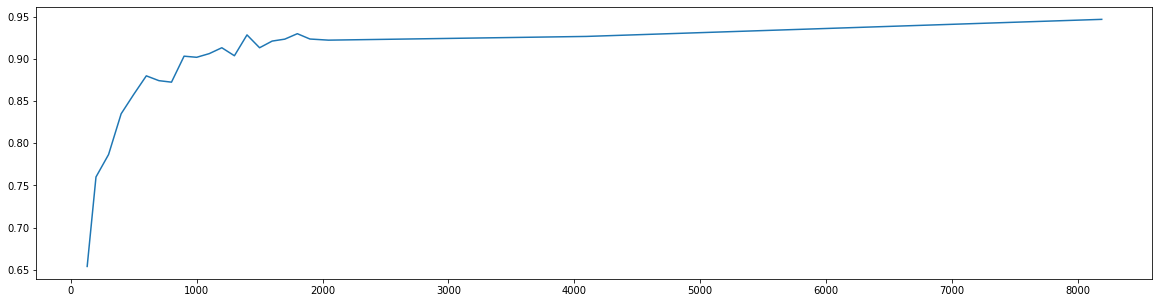

In [6]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['n_data'][:-3], accuracies['best score'][:-3])
plt.show()

### Provo ad alzare il numero di neuroni dato che aumentando i dati è fisso a 10, che è il massimo. Si nota un miglioramento, l'accuracy si avvicina molto a 1

In [7]:
params = {'activation': ['relu', 'logistic', 'tanh'],
          'hidden_layer_sizes' : [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10), (20), (30), (50)]}

accuracies = get_accuracies(X, y, params)
accuracies

n_data activation  hidden layer sizes  best score
0      130   logistic                  20    0.653846
1      200       tanh                  20    0.795000
2      300       tanh                  50    0.863333
3      400       tanh                  20    0.907500
4      500       tanh                  50    0.932000
5      600       tanh                  50    0.943333
6      700       tanh                  50    0.955714
7      800       relu                  30    0.950000
8      900       tanh                  50    0.948889
9     1000       tanh                  50    0.959000
10    1100       relu                  50    0.956364
11    1200       tanh                  50    0.959167
12    1300       tanh                  50    0.975385
13    1400       relu                  50    0.965714
14    1500       relu                  50    0.965333
15    1600       relu                  50    0.963750
16    1700       tanh                  50    0.976471
17    1800       tanh                  50    0.970556
18    1900       tanh                  50    0.983158
19    2048       tanh                  50    0.978520
20    4096       tanh                  50    0.989503
21    8192       tanh                  50    0.994263
22   16384       tanh                  50    0.997131
23   32768       tanh                  50    0.998260
24   65536       tanh                  50    0.998947

In [8]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['n_data'], accuracies['best score'])
plt.show()

In [9]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['n_data'][:-3], accuracies['best score'][:-3])
plt.show()

Qua ho provato ad usare la funzione utilizzata l'ultima volta per fare model selection e vedere le accuracy su 130 dati generati con SMOTE presi a random. L'accuratezza è migliore che con i nostri dati.

In [10]:
def get_summary(X, y):
    activations = ['relu', 'logistic', 'tanh']
    hidden_layers = [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10), (2,2,2)]

    summary = {"Activation" : [], "Hidden layer sizes" : [], "Scores" : [], "Mean score" : [], "Scores std" : []}

    for activation in activations:
        for hidden_layer in hidden_layers:
            mlp = MLPClassifier(activation=activation, hidden_layer_sizes=hidden_layer, learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")

            scores = cross_val_score(mlp, X, y)

            summary["Scores"].append(list(map(lambda x : round(x, 3), scores)))
            summary["Mean score"].append(round(scores.mean(), 3))
            summary["Scores std"].append(round(scores.std(), 3))
            summary["Activation"].append(activation)
            summary["Hidden layer sizes"].append(hidden_layer)

    summ = pd.DataFrame(summary)
    return summ.sort_values('Mean score', ascending=False)

In [11]:
smote = SMOTE(sampling_strategy={0 : 200, 1 : 200})
X_os, y_os = smote.fit_resample(X, y)

seed = np.random.randint(0,10000)
X_test, y_test = X_os[130:].sample(n=130, random_state=seed), y_os[130:].sample(n=130, random_state=seed)

In [12]:
get_summary(X_test, y_test)

Activation Hidden layer sizes                               Scores  \
25       tanh                 10  [0.885, 0.769, 0.731, 0.885, 0.731]   
15   logistic                  8  [0.846, 0.808, 0.769, 0.808, 0.769]   
14   logistic                  6  [0.885, 0.731, 0.731, 0.846, 0.808]   
24       tanh                  8  [0.885, 0.808, 0.692, 0.846, 0.731]   
16   logistic                 10  [0.808, 0.808, 0.692, 0.846, 0.769]   
7        relu                 10  [0.731, 0.769, 0.731, 0.769, 0.846]   
5        relu                  6  [0.654, 0.808, 0.692, 0.731, 0.846]   
11   logistic                  5    [0.808, 0.808, 0.5, 0.769, 0.731]   
6        relu                  8  [0.538, 0.731, 0.731, 0.731, 0.808]   
23       tanh                  6    [0.5, 0.808, 0.538, 0.885, 0.769]   
2        relu                  5  [0.615, 0.577, 0.692, 0.808, 0.654]   
3        relu             (6, 3)      [0.808, 0.5, 0.654, 0.5, 0.885]   
9    logistic                  2    [0.5, 0.808, 0.654, 0.769, 0.538]   
21       tanh             (6, 3)    [0.5, 0.808, 0.769, 0.462, 0.731]   
4        relu             (5, 5)      [0.5, 0.731, 0.654, 0.5, 0.808]   
13   logistic             (5, 5)      [0.923, 0.808, 0.5, 0.5, 0.462]   
18       tanh                  2      [0.5, 0.769, 0.5, 0.808, 0.538]   
12   logistic             (6, 3)      [0.5, 0.5, 0.654, 0.538, 0.808]   
10   logistic             (3, 3)      [0.846, 0.5, 0.5, 0.577, 0.462]   
19       tanh             (3, 3)      [0.808, 0.5, 0.5, 0.577, 0.462]   
22       tanh             (5, 5)      [0.5, 0.731, 0.615, 0.5, 0.462]   
0        relu                  2        [0.808, 0.5, 0.5, 0.5, 0.462]   
1        relu             (3, 3)        [0.731, 0.5, 0.538, 0.5, 0.5]   
20       tanh                  5        [0.462, 0.5, 0.5, 0.5, 0.769]   
8        relu          (2, 2, 2)          [0.5, 0.5, 0.5, 0.615, 0.5]   
26       tanh          (2, 2, 2)        [0.5, 0.5, 0.5, 0.538, 0.538]   
17   logistic          (2, 2, 2)          [0.5, 0.5, 0.5, 0.5, 0.538]   

    Mean score  Scores std  
25       0.800       0.071  
15       0.800       0.029  
14       0.800       0.062  
24       0.792       0.071  
16       0.785       0.052  
7        0.769       0.042  
5        0.746       0.071  
11       0.723       0.115  
6        0.708       0.090  
23       0.700       0.153  
2        0.669       0.079  
3        0.669       0.157  
9        0.654       0.122  
21       0.654       0.144  
4        0.638       0.123  
13       0.638       0.189  
18       0.623       0.136  
12       0.600       0.118  
10       0.577       0.140  
19       0.569       0.125  
22       0.562       0.099  
0        0.554       0.128  
1        0.554       0.090  
20       0.546       0.113  
8        0.523       0.046  
26       0.515       0.019  
17       0.508       0.015

# Data augmentation con la funzione fatta da Manuel Dileo

In [13]:
def add_new_elements(error_distrib,n_elements,n_columns,dataset,\
                     label_col):
    
    x = error_distrib['x']
    px = error_distrib['px']
    
    count_elements = 0
    
    df_result = dataset
    
    eq_freq = []
    count_neq_label = 0
    
    while True:
        #Scelta elemento da cui partire
        from_item = np.random.choice(dataset.index)
        elem = dataset[dataset.index==from_item]
        new_index = ['F'+str(ind) for ind in list(elem.index)]
        elem.rename({from_item:'FAKE'+str(from_item)},inplace=True)
        
        
        #scelta colonne da perturbare
        columns = set()
        columns_to_extract = list(set(dataset.columns)-set([label_col]))
        while(len(columns)!=n_columns):
            extract = np.random.choice(columns_to_extract)
            columns.add(extract)
            columns_to_extract = list(set(columns_to_extract)-set([extract]))
        columns_list = list(columns)
        
                       
        #perturbazione
        for col in columns_list:
            #check rimanga in valori del dominio
            while True:
                perturbation = np.random.choice(x,p=px)
                new_value = elem.iloc[0][col]+perturbation
                if new_value >= 0 and new_value<=4: break
            elem[col]=new_value
        
        #check elementi uguali
        eq_list = [x for x,y in dataset.iterrows() if all(y==elem.iloc[0])]
        if len(eq_list)>0:
            eq_item = eq_list[0]
            eq_label = elem.iloc[0][label_col]\
                        == dataset.loc[eq_item][label_col] 
            eq_freq.append(count_elements)
            if not eq_label:
                count_neq_label+=1
            """
            warn("Creato un elemento già presente"+\
                " ho perturbato {} colonne".format(n_columns)+\
                " ho già creato {} elementi".format(count_elements)+\
                " px: {}".format(px)+\
                " label uguali: {}".format(eq_label))
            """
        else:
            count_elements+=1
            df_result = df_result.append(elem)
        
        if count_elements==n_elements: break
            
    return df_result,eq_freq,count_neq_label

In [14]:
def augment_data(df, n_data):
    raw_df = df.drop(columns=(['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro', 'Totale']))

    error_distrib = {
        'x' : [-2,-1,0,1,2],
        'px' : [.1,.2,.4,.2,.1]
    }

    df_end, _, _ = add_new_elements(error_distrib, n_data - len(df), 3, raw_df, 'Mezzo')
    
    df_augmented = pd.DataFrame(df_end['Mezzo'])
    parti_corpo = ['Testa', 'Torace', 'Addome', 'Scheletro']
    sum_parte_corpo =  {'Testa' : [], 'Torace' : [], 'Addome' : [], 'Scheletro' : []}

    for index, row in df_end.iterrows():
        for parte_corpo in parti_corpo:
            sum_parte_corpo[parte_corpo].append(sum(row.filter(regex=parte_corpo+":")))


    for parte_corpo in parti_corpo:
        df_augmented['Tot ' + parte_corpo] = sum_parte_corpo[parte_corpo]
    
    X_augmented = df_augmented.drop(columns='Mezzo')
    y_augmented = df_augmented['Mezzo']
    
    return X_augmented, y_augmented

In [20]:
def get_accuracies_2(df, X, y, params): 
    accuracies = {'n_data' : [], 'activation': [], 'hidden layer sizes' : [], 'best score' : []}

    mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
    clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
    clf.fit(X,y)

    accuracies['n_data'].append(len(y))
    accuracies['activation'].append(clf.best_estimator_.activation)
    accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
    accuracies['best score'].append(clf.best_score_)

    for n_data in [2**x for x in range(8,15)]:
        
        X_os, y_os = augment_data(df, n_data)

        X_os_std = StandardScaler().fit_transform(X_os)

        mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
        clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
        clf.fit(X_os_std,y_os)

        accuracies['n_data'].append(len(y_os))
        accuracies['activation'].append(clf.best_estimator_.activation)
        accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
        accuracies['best score'].append(clf.best_score_)

    return pd.DataFrame(accuracies)

In [21]:
acc = get_accuracies_2(df, X, y, params)

# Accuratezze con la tecnica di Manuel

In [22]:
acc

n_data activation  hidden layer sizes  best score
0     130   logistic                   8    0.646154
1     256       relu                  20    0.679638
2     512       relu                  50    0.732381
3    1024       relu                  50    0.773439
4    2048       tanh                  50    0.817873
5    4096       relu                  50    0.814942
6    8192       tanh                  50    0.820801
7   16384   logistic                  50    0.835816

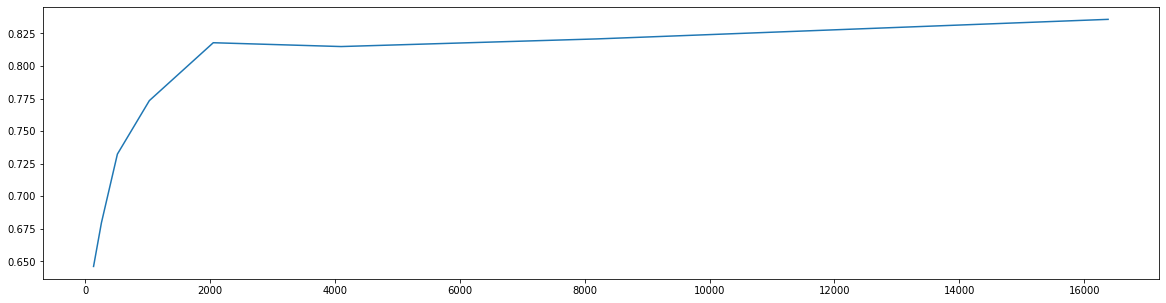

In [23]:
plt.figure(figsize=(20,5))
plt.plot(acc['n_data'], acc['best score'])
plt.show()